# Using Intel python and pandas 

    1. LDA takes a lot of time in traning. Can't use in production environment. 
    2. Next Notebook will be on Online Distributed Concept based LDA 

In [1]:
%%time
%matplotlib inline
ROOT_DATA_DIR = "../data/pdf_extract/"
OUTPUT_DIR = "../dataset/"
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
from multiprocessing import Pool

from nltk import stem

sns.set_style("darkgrid")

CPU times: user 3.06 s, sys: 997 ms, total: 4.05 s
Wall time: 6.07 s


In [2]:
%%time
data = []
def load_text(filename):
    with open(ROOT_DATA_DIR+filename, 'r', encoding='ascii', errors='replace') as f:
        local_data = {}
        text = f.read()
        local_data["text"] = str(text)
        local_data["filename"] = filename
        f.close()
        data.append(local_data)
dirs = os.listdir(ROOT_DATA_DIR)
for filename in dirs:
    load_text(filename)

CPU times: user 28.5 s, sys: 17.2 s, total: 45.7 s
Wall time: 1min 25s


In [3]:
%%time
df = pd.DataFrame(data)


CPU times: user 250 ms, sys: 1.13 s, total: 1.38 s
Wall time: 4.14 s


In [198]:
df.head(10)

,filename,text
0,math9912086.txt,...
1,1801.04962v1.pdf.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
2,nucl-th9508029.txt,Do ...
3,cond-mat0012192.txt,                                             ...
4,hep-th0010224.txt,Pseudoconf...
5,1802.01952.txt,Vol...
6,cond-mat0307527.txt,...
7,1202.1863.txt,...
8,hep-ph0301113.txt,EPJ manus...
9,0704.2155.txt,...


In [162]:
print(len(df))
df_10 = df.sample(frac=0.3)
print(len(df_10))

64937
19481


In [123]:
# for dataframe partition 
num_partitions = 80 #number of partitions to split dataframe
# num_cores = 1 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool()
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def encode_df(data):
    data['text'] = data['text'].apply(lambda x: str(x, errors='ignore'))
    return data

def clean_df(df):
    start = time.time()
    print('Process working on: ',os.getpid())
    df['tokenized'] = df['text'].apply(lambda x: apply_all(x))
    print('Process done:',os.getpid(),'record:', filename)
    print()
    end = time.time()
    print("time to complete :", end-start)
    return df

# For data cleaning 
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = stem.PorterStemmer()

def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [124]:
# %%time
# data = parallelize_dataframe(df, clean_df)

In [125]:
# %%time
# df["text"] = df["text"].apply(lambda x: x.replace("\n", " "))
# df["text"] = df["text"].apply(lambda x: x.replace("\t", " "))

# # df["text"] = df["text"].apply(lambda x: nlp(x))

In [126]:
data = parallelize_dataframe(df_10, clean_df)

Process working on:  13001
Process working on:  13002
Process working on:  13003
Process working on:  13004
Process done: 13001 record: cond-mat0310042.txt

time to complete : 38.55350708961487
Process working on:  13001
Process done: 13003 record: cond-mat0310042.txt

time to complete : 40.66481399536133
Process working on:  13003
Process done: 13002 record: cond-mat0310042.txt

time to complete : 46.28430795669556
Process working on:  13002
Process done: 13004 record: cond-mat0310042.txt

time to complete : 43.52053904533386
Process working on:  13004
Process done: 13001 record: cond-mat0310042.txt

time to complete : 35.62822103500366
Process working on:  13001
Process done: 13003 record: cond-mat0310042.txt

time to complete : 44.9926278591156
Process working on:  13003
Process done: 13002 record: cond-mat0310042.txt

time to complete : 44.560816049575806
Process working on:  13002
Process done: 13004 record: cond-mat0310042.txt

time to complete : 48.088977098464966
Process workin


time to complete : 29.333445072174072
Process working on:  13002
Process done: 13003 record: cond-mat0310042.txt

time to complete : 31.510931968688965
Process working on:  13003
Process done: 13004 record: cond-mat0310042.txt

time to complete : 27.45409393310547
Process working on:  13004
Process done: 13001 record: cond-mat0310042.txt

time to complete : 23.993489027023315
Process working on:  13001
Process done: 13003 record: cond-mat0310042.txt

time to complete : 25.117523908615112
Process working on:  13003
Process done: 13004 record: cond-mat0310042.txt

time to complete : 26.929558992385864
Process done: 13002 record: cond-mat0310042.txt

time to complete : 32.31842589378357
Process done: 13001 record: cond-mat0310042.txt

time to complete : 24.645487070083618
Process done: 13003 record: cond-mat0310042.txt

time to complete : 18.994663953781128


In [127]:
# first get a list of all words
all_words = [word for item in list(data['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

961939

In [150]:
k = 300000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('spherelet', 2),
 ('antipodeinvari', 2),
 ('truncationmethod', 2),
 ('obviouslyx', 2),
 ('particlesclos', 2),
 ('celmn', 2),
 ('descriptioncan', 2),
 ('wenand', 2),
 ('yyk', 2),
 ('baselineof', 2)]

In [151]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [152]:
data['tokenized'] = data['tokenized'].apply(keep_top_k_words)

In [160]:
len(data['tokenized'])

6492

In [155]:
# document length
data['doc_len'] = data['tokenized'].apply(lambda x: len(x))
doc_lengths = list(data['doc_len'])
data.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 6492 
average document length 3061.2866605052373 
minimum document length 49 
maximum document length 38296


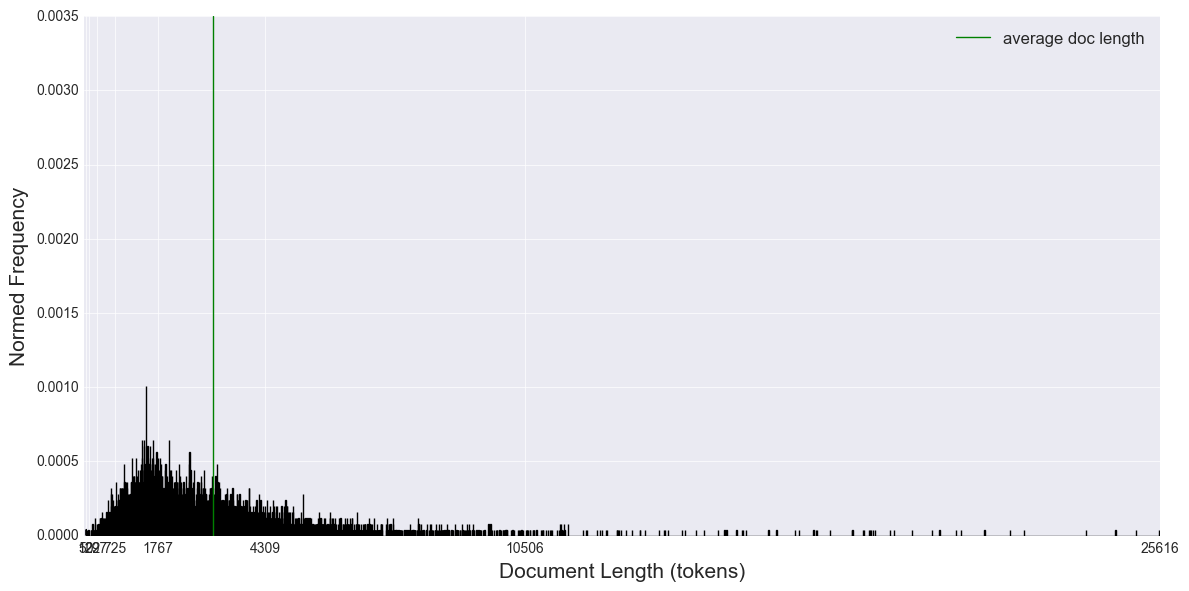

In [158]:
# plot a histogram of document length
num_bins = 10000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(25616),num=8, base=10.0))
plt.xlim(0,25616)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [163]:
# only keep articles with more than 30 tokens, otherwise too short
data = data[data['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
data = data[data['tokenized'].map(type) == list]
data.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(data), "articles")

After cleaning and excluding short aticles, the dataframe now has: 6492 articles


In [164]:
data.head()

,filename,text,tokenized
0,1404.1706.txt,...,"[nuclear, physic, nuclear, physic, dijet, asym..."
1,hep-ph0508317.txt,...,"[ect, studi, gluon, propag, largenf, limit, ni..."
2,solv-int9811004.txt,                                             ...,"[transform, qdeform, kortewegd, vri, hierarchi..."
3,cond-mat0012178.txt,                                             ...,"[pseudospectr, approach, invers, problem, inte..."
4,hep-ph9609390.txt,H...,"[heavi, baryon, relativist, quark, model, nonl..."


In [165]:
# create a mask of binary values
msk = np.random.rand(len(data)) > 0.09

In [166]:
msk = np.random.rand(len(data)) > 0.09
train_data = data[msk]
train_data.reset_index(drop=True,inplace=True)

test_data = data[~msk]
test_data.reset_index(drop=True,inplace=True)

In [167]:
print(len(data),len(train_data),len(test_data))

6492 5881 611


In [179]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 1000
    chunksize = 3000
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [180]:
dictionary,corpus,lda = train_lda(train_data)


Time to train LDA model on  64937 articles:  23.00232243537903 min


In [181]:
lda.show_topic(topicid=8, topn=15)

[('algebra', 0.013201558),
 ('let', 0.012197618),
 ('volcan', 0.012136823),
 ('represent', 0.0076001617),
 ('polynomi', 0.0074237697),
 ('tutt', 0.006756909),
 ('invari', 0.00657914),
 ('ncompon', 0.0062820055),
 ('myear', 0.005383278),
 ('milnor', 0.005304985),
 ('unitriangular', 0.005261467),
 ('group', 0.004528883),
 ('follow', 0.0044094175),
 ('multiplicityfre', 0.0042706057),
 ('xg', 0.004240671)]

In [171]:
random_article_index = np.random.randint(len(train_data))
bow = dictionary.doc2bow(train_data.iloc[random_article_index, 2])
print(random_article_index)

30


In [172]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])


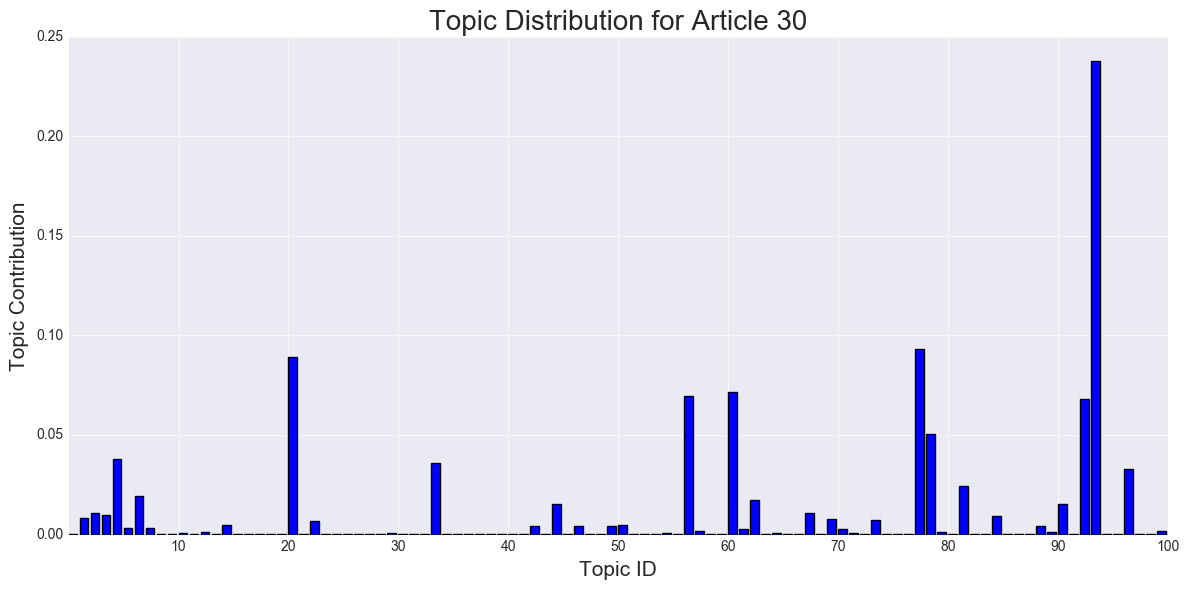

In [173]:
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [174]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

93 [('gaug', 0.020414561), ('phi', 0.016573036), ('theori', 0.015732203), ('term', 0.014779134), ('field', 0.0144401565), ('one', 0.00935116), ('invari', 0.008152069), ('order', 0.007445638), ('action', 0.0071518486), ('eq', 0.0064769406)] 

77 [('equat', 0.03572111), ('eq', 0.02675858), ('function', 0.026062962), ('solut', 0.02009988), ('integr', 0.013906293), ('term', 0.01380522), ('case', 0.01023691), ('obtain', 0.010020665), ('one', 0.009669782), ('use', 0.009616446)] 

20 [('energi', 0.025638456), ('potenti', 0.015360644), ('phi', 0.014734086), ('phase', 0.013300311), ('scale', 0.0113658495), ('effect', 0.011267002), ('temperatur', 0.0109878555), ('interact', 0.010195339), ('rev', 0.009777705), ('correl', 0.009702978)] 

60 [('phi', 0.013678344), ('fig', 0.012393037), ('rev', 0.011884848), ('mode', 0.011399072), ('current', 0.010349605), ('electron', 0.009245483), ('effect', 0.008854782), ('coupl', 0.0079717), ('field', 0.007531831), ('lett', 0.007221799)] 

56 [('state', 0.057429

In [175]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_data))
print(random_article_index)

52


In [191]:
new_bow = dictionary.doc2bow(test_data.iloc[random_article_index,2])


In [192]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

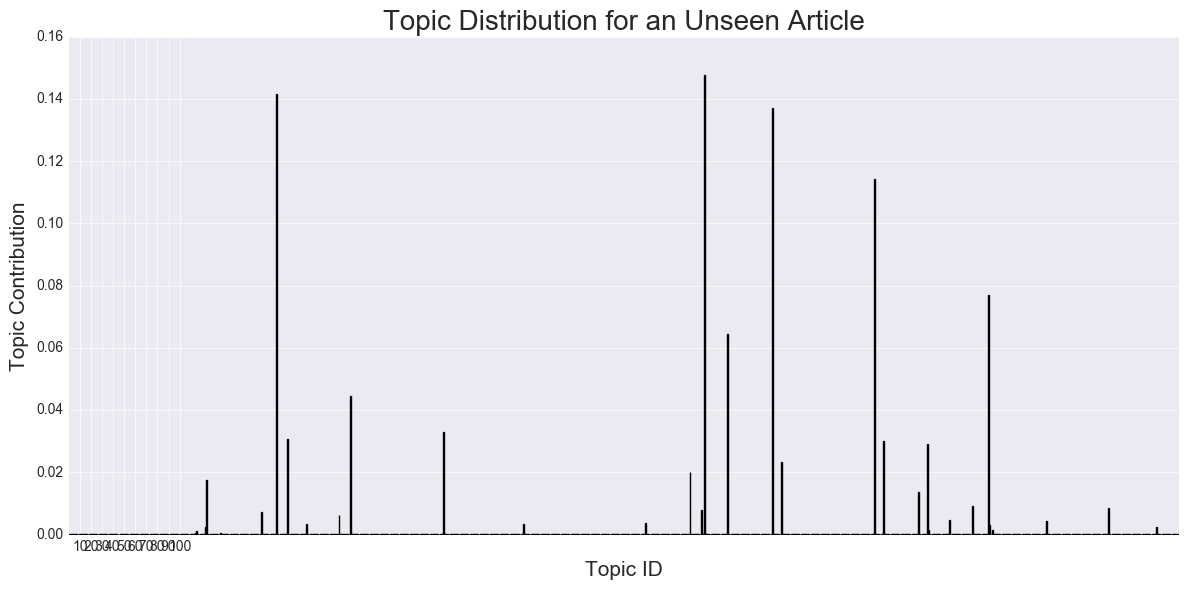

In [190]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

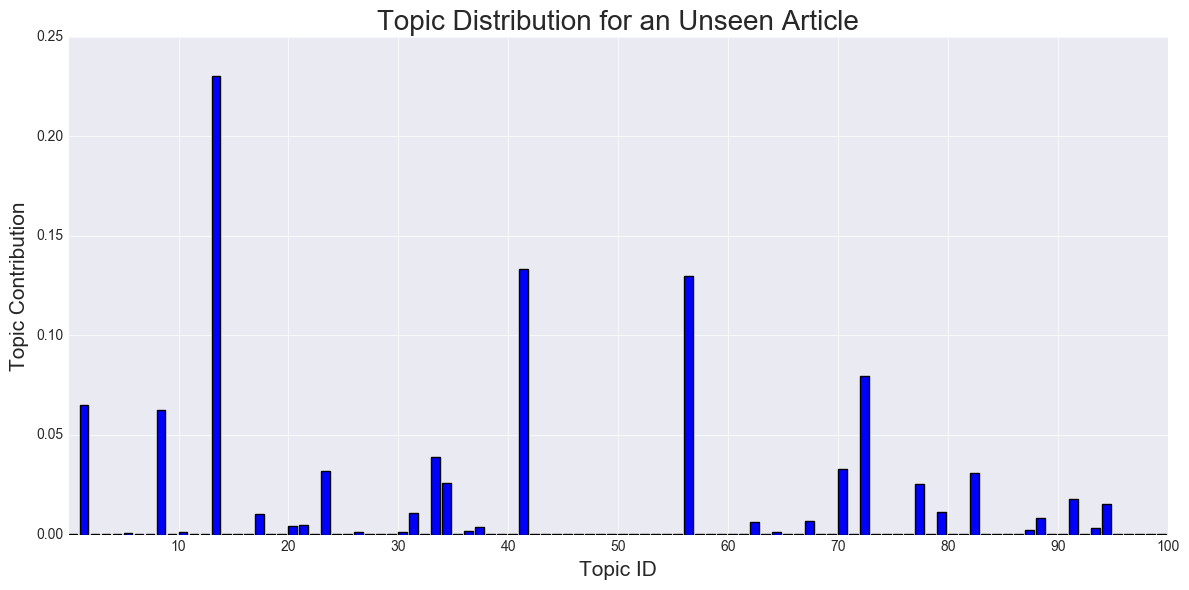

In [178]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [182]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

13 [('set', 0.0050384114), ('one', 0.004569648), ('use', 0.0038715608), ('state', 0.0029656205), ('follow', 0.0025684533), ('result', 0.0025476792), ('also', 0.0025282893), ('function', 0.0024391143), ('gener', 0.0024176834), ('case', 0.0023384816)] 

41 [('ezk', 0.01651736), ('homd', 0.011870058), ('kloosterman', 0.010993052), ('newform', 0.008335269), ('excurs', 0.008075485), ('zyx', 0.007810206), ('kdc', 0.00773646), ('one', 0.0072398717), ('process', 0.006558044), ('function', 0.005805171)] 

56 [('dissect', 0.060906947), ('result', 0.004219263), ('one', 0.004169994), ('number', 0.0036269808), ('use', 0.0034083594), ('phenomenon', 0.0028028279), ('sn', 0.002780906), ('case', 0.0026595758), ('section', 0.0026210626), ('point', 0.0025876695)] 

72 [('geck', 0.029882701), ('et', 0.0041863234), ('phi', 0.0031367226), ('al', 0.0030785636), ('use', 0.0030668823), ('paramet', 0.0030391486), ('bs', 0.0027683557), ('case', 0.0027381983), ('one', 0.0025689213), ('sampl', 0.0022942629)] 

1 [

In [193]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(5881, 1000)

In [194]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [195]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances


In [196]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)